In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Epoch 1: Train Acc 0.7629 | Val Acc 0.7911 | Train Loss 0.6704 | Val Loss 0.5964
Epoch 2: Train Acc 0.8215 | Val Acc 0.8137 | Train Loss 0.5008 | Val Loss 0.5291
Epoch 3: Train Acc 0.8373 | Val Acc 0.8377 | Train Loss 0.4491 | Val Loss 0.4443
Epoch 4: Train Acc 0.8433 | Val Acc 0.8357 | Train Loss 0.4320 | Val Loss 0.4473
Epoch 5: Train Acc 0.8517 | Val Acc 0.8397 | Train Loss 0.4103 | Val Loss 0.4334
Epoch 6: Train Acc 0.8589 | Val Acc 0.8330 | Train Loss 0.3865 | Val Loss 0.4430
Epoch 7: Train Acc 0.8776 | Val Acc 0.8483 | Train Loss 0.3422 | Val Loss 0.4342
Epoch 8: Train Acc 0.8897 | Val Acc 0.8596 | Train Loss 0.3050 | Val Loss 0.4111
Epoch 9: Train Acc 0.9078 | Val Acc 0.8443 | Train Loss 0.2645 | Val Loss 0.4256
Epoch 10: Train Acc 0.9203 | Val Acc 0.8390 | Train Loss 0.2180 | Val Loss 0.4742
Epoch 11: Train Acc 0.9381 | Val Acc 0.8636 | Train Loss 0.1696 | Val Loss 0.4529
Epoch 12: Train Acc 0.9628 | Val Acc 0.8876 | Train Loss 0.1119 | Val Loss 0.3679
Epoch 13: Train Acc 0.971

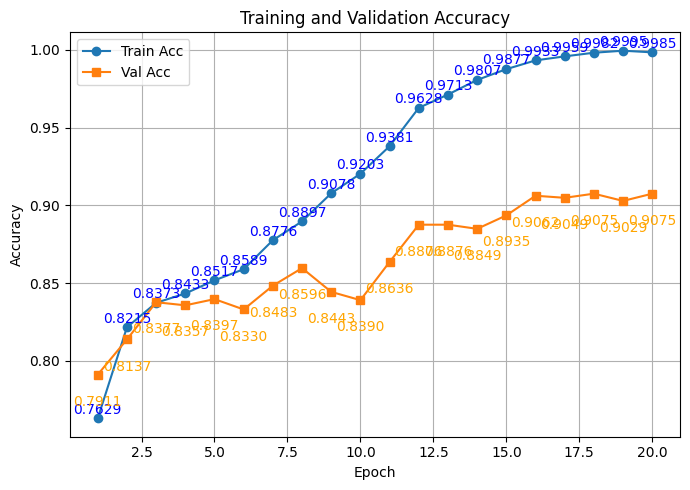

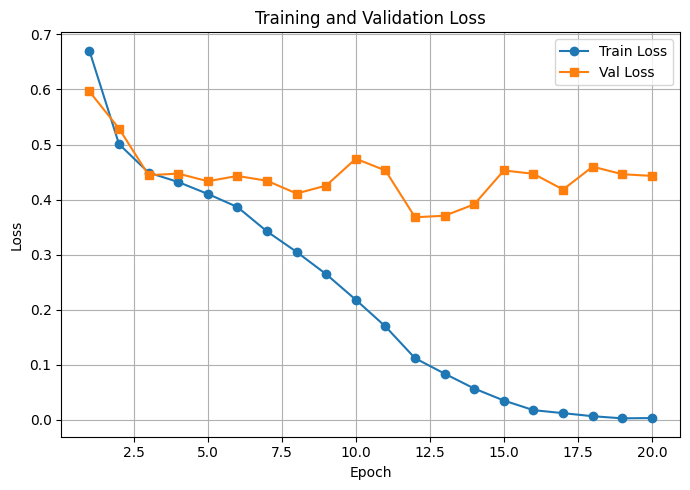


Performance Table (like Table 1):
Model         Accuracy (%)   Precision (%)  Recall (%)     F1-score (%)   AUC       
ConvNeXt      90.75          90.58          90.75          90.58          nan
Could not include img24.jpg in PDF: [Errno 2] No such file or directory: 'img24.jpg'
Saved phase1_results_report.pdf with all requested elements.


ModuleNotFoundError: No module named 'torchcam'

In [2]:
# phase 1 to 3
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Scikit-learn (for preprocessing and metrics)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    roc_auc_score, precision_score, recall_score, jaccard_score
)

# PyTorch and torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# For advanced learning rate scheduling
from torch.optim.lr_scheduler import OneCycleLR

# TIMM and segmentation models (if needed for pipelines)
from timm import create_model

# PDF export for reporting
from matplotlib.backends.backend_pdf import PdfPages

# GradCAM and SMP (install via pip if not found)
# from torchcam.methods import GradCAM
# import segmentation_models_pytorch as smp

# For globbing mask files if needed
import glob


# ==== PHASE 1: Train Classifier, Record All Metrics, and Save Results/Plots ====
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from timm import create_model
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report,
                             roc_auc_score, precision_score, recall_score)
from torchvision import transforms

SEED = 42
BATCH_SIZE = 8      # Use 8 (or lower) to avoid OOM errors, can go up if you have more GPU RAM
EPOCHS = 20
IMG_SIZE = 224
LEARNING_RATE = 3e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(SEED)
torch.manual_seed(SEED)

IMAGE_DIR_1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
IMAGE_DIR_2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
CSV_PATH = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

df = pd.read_csv(CSV_PATH)
df['path'] = df['image_id'].apply(
    lambda x: os.path.join(IMAGE_DIR_1, f"{x}.jpg") if os.path.exists(os.path.join(IMAGE_DIR_1, f"{x}.jpg"))
    else os.path.join(IMAGE_DIR_2, f"{x}.jpg")
)
df = df[df['dx'].notnull()].copy()
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])
df['age'] = df['age'].fillna(df['age'].mean())
df['sex'] = df['sex'].map({'male': 1, 'female': 0}).fillna(0.5)
df = pd.get_dummies(df, columns=['localization'], dummy_na=True)
meta_cols = ['age', 'sex'] + [c for c in df.columns if c.startswith('localization_')]
scaler = StandardScaler()
df[meta_cols] = scaler.fit_transform(df[meta_cols])
for col in meta_cols:
    df[col] = df[col].astype(float)

train_df, val_df = train_test_split(df, stratify=df['label'], test_size=0.15, random_state=SEED)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(12),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class SimpleDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img = Image.open(self.df.loc[idx, 'path']).convert('RGB')
        dataimg = self.transform(img)
        meta_arr = self.df.loc[idx, meta_cols].values.astype(np.float32)
        meta = torch.tensor(meta_arr, dtype=torch.float32)
        label = int(self.df.loc[idx, 'label'])
        return dataimg, meta, label

trainset = SimpleDataset(train_df, transform)
valset = SimpleDataset(val_df, transform)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

class MetaImageClassifier(nn.Module):
    def __init__(self, model_name, num_classes, meta_dim):
        super().__init__()
        self.model = create_model(model_name, pretrained=True, num_classes=0)
        last_dim = None
        for att in ['head', 'classifier', 'fc']:
            if hasattr(self.model, att):
                last_dim = getattr(self.model, att).in_features
                break
        self.meta_bn = nn.BatchNorm1d(meta_dim)
        self.final = nn.Linear(last_dim + meta_dim, num_classes)
    def forward(self, x, meta):
        features = self.model(x)
        meta_norm = self.meta_bn(meta)
        concat = torch.cat([features, meta_norm], 1)
        return self.final(concat)

num_classes = len(le.classes_)
meta_dim = len(meta_cols)
model = MetaImageClassifier('convnext_base', num_classes, meta_dim).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
from torch.optim.lr_scheduler import OneCycleLR
scheduler = OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=EPOCHS)
criterion = nn.CrossEntropyLoss()

# --- Phase 1 Training ---
train_accs, val_accs = [], []
train_losses, val_losses = [], []
best_acc = 0.0
best_outputs = None
for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, meta, labels in train_loader:
        imgs, meta, labels = imgs.to(DEVICE), meta.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        out = model(imgs, meta)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(out, 1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    train_acc = correct / total
    train_loss = running_loss / total
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_y, all_p = [], []
    with torch.no_grad():
        for imgs, meta, labels in val_loader:
            imgs, meta, labels = imgs.to(DEVICE), meta.to(DEVICE), labels.to(DEVICE)
            out = model(imgs, meta)
            val_loss = criterion(out, labels)
            preds = torch.argmax(out, 1)
            all_y.append(labels.cpu().numpy())
            all_p.append(preds.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += val_loss.item() * labels.size(0)
    val_acc = correct / total
    val_loss = running_loss / total
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    all_y_flat = np.concatenate(all_y)
    all_p_flat = np.concatenate(all_p)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_classifier.pth")
        best_outputs = (all_y_flat, all_p_flat)
    print(f"Epoch {epoch+1}: Train Acc {train_acc:.4f} | Val Acc {val_acc:.4f} | Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f}")

# --- Save Accuracy/Loss Plots with Metrics ---
epochs = range(1, EPOCHS+1)
plt.figure(figsize=(7,5))
plt.plot(epochs, train_accs, marker='o', label='Train Acc')
plt.plot(epochs, val_accs, marker='s', label='Val Acc')
for i in range(EPOCHS):
    plt.text(epochs[i], train_accs[i]+.003, f"{train_accs[i]:.4f}", ha='center', color='blue', fontsize=10)
    plt.text(epochs[i], val_accs[i]-.02, f"{val_accs[i]:.4f}", ha='center', color='orange', fontsize=10)
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training and Validation Accuracy')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.savefig('phase1_accuracy_curve.png', dpi=120); plt.show()

plt.figure(figsize=(7,5))
plt.plot(epochs, train_losses, '-o', label='Train Loss')
plt.plot(epochs, val_losses, '-s', label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.savefig('phase1_loss_curve.png', dpi=120); plt.show()

# === Table 1-like performance metrics
y_true, y_pred = best_outputs
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall    = recall_score(y_true, y_pred,   average='weighted') * 100
f1        = f1_score(y_true, y_pred,       average='weighted') * 100
acc       = accuracy_score(y_true, y_pred) * 100
try:
    from sklearn.preprocessing import label_binarize
    y_score = []
    model.eval()
    for imgs, meta, labels in val_loader:
        imgs, meta = imgs.to(DEVICE), meta.to(DEVICE)
        logits = model(imgs, meta)
        y_score.append(torch.softmax(logits, 1).cpu().numpy())
    y_score = np.concatenate(y_score, axis=0)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    auc_score = roc_auc_score(y_true_bin, y_score, average='weighted', multi_class='ovr')
except Exception:
    auc_score = np.nan

print("\nPerformance Table (like Table 1):")
print(f"{'Model':<14}{'Accuracy (%)':<15}{'Precision (%)':<15}{'Recall (%)':<15}{'F1-score (%)':<15}{'AUC':<10}")
print(f"{'ConvNeXt':<14}{acc:<15.2f}{precision:<15.2f}{recall:<15.2f}{f1:<15.2f}{auc_score:.3f}")

with PdfPages('phase1_results_report.pdf') as pdf:
    fig1 = plt.figure(figsize=(7,5))
    plt.plot(epochs, train_accs, marker='o', label='Train Acc')
    plt.plot(epochs, val_accs, marker='s', label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training and Validation Accuracy')
    plt.legend(); plt.grid(True)
    pdf.savefig(fig1); plt.close(fig1)
    fig2 = plt.figure(figsize=(7,5))
    plt.plot(epochs, train_losses, '-o', label='Train Loss')
    plt.plot(epochs, val_losses, '-s', label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
    plt.legend(); plt.grid(True)
    pdf.savefig(fig2); plt.close(fig2)
    fig3, ax3 = plt.subplots(figsize=(8, 1))
    ax3.axis('tight'); ax3.axis('off')
    Tbl = [[
        "ConvNeXt",
        f"{acc:.2f}",
        f"{precision:.2f}",
        f"{recall:.2f}",
        f"{f1:.2f}",
        f"{auc_score:.3f}"
    ]]
    colLabels= ["Model","Accuracy (%)","Precision (%)","Recall (%)","F1-score (%)","AUC"]
    ax3.table(cellText=Tbl, colLabels=colLabels, loc='center', cellLoc='center')
    pdf.savefig(fig3); plt.close(fig3)
    try:
        img24 = Image.open('img24.jpg')
        fig4 = plt.figure(figsize=(3,3))
        plt.imshow(img24)
        plt.title("Sample Image (img24)")
        plt.axis('off')
        pdf.savefig(fig4); plt.close(fig4)
    except Exception as e:
        print("Could not include img24.jpg in PDF:", str(e))
print("Saved phase1_results_report.pdf with all requested elements.")

# ========== PHASE 2: Grad-CAM + Pseudo-Masks ==========
from torchcam.methods import GradCAM
import cv2
for col in meta_cols:
    val_df[col] = val_df[col].astype(float)
os.makedirs('pseudo_masks', exist_ok=True)
os.makedirs('cam_overlays', exist_ok=True)
model.load_state_dict(torch.load('best_classifier.pth', map_location=DEVICE))
model.to(DEVICE)
model.eval()
target_layer = model.model.stages[-1].blocks[-1]
cam_extractor = GradCAM(model, target_layer=target_layer)
pseudo_mask_paths = []
cam_overlay_imgs = []

for idx, row in val_df.iterrows():
    img_path = row['path']
    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    input_tensor = transform(img).unsqueeze(0).to(DEVICE)
    meta_arr = row[meta_cols].values.astype(np.float32)
    meta = torch.tensor(meta_arr, dtype=torch.float32).unsqueeze(0).to(DEVICE)
    out = model(input_tensor, meta)
    class_idx = out.argmax(dim=1).item()
    cam = cam_extractor(class_idx, out)[0].cpu().numpy()
    cam = np.squeeze(cam)
    if cam.shape != (IMG_SIZE, IMG_SIZE):
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    cam_normalized = ((cam - cam.min()) / (cam.max() - cam.min() + 1e-8) * 255).astype(np.uint8)
    cam_gray = cam_normalized
    _, mask = cv2.threshold(cam_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, np.ones((3,3), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, np.ones((3,3), np.uint8))
    mask_path = f"pseudo_masks/mask_{idx}.png"
    cv2.imwrite(mask_path, mask)
    pseudo_mask_paths.append(mask_path)
    cmap = plt.get_cmap('jet')
    cam_rgb = (cmap(cam_gray / 255.0)[..., :3] * 255).astype(np.uint8)
    img_np = np.array(img)
    if cam_rgb.shape != img_np.shape:
        cam_rgb = cv2.resize(cam_rgb, (img_np.shape[1], img_np.shape[0]))
    overlay = (0.5 * img_np + 0.5 * cam_rgb).astype(np.uint8)
    overlay_path = f"cam_overlays/cam_{idx}.png"
    cv2.imwrite(overlay_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    if idx < 20:
        cam_overlay_imgs.append(overlay_path)

with PdfPages('cam_overlay_examples.pdf') as pdf:
    for img_path in cam_overlay_imgs:
        img = plt.imread(img_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        pdf.savefig()
        plt.close()

print("Phase 2 complete: Pseudo-masks saved in 'pseudo_masks/', overlays in 'cam_overlays/', PDF sample as 'cam_overlay_examples.pdf'")


# === PHASE 3: Training U-Net Segmentation on CAM-generated Pseudo-Masks ===

# If not done: !pip install -U segmentation-models-pytorch

import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import jaccard_score, precision_score, recall_score
import numpy as np

# --- CONFIG ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 224
BATCH_SIZE = 8   # Lower if GPU is limited
EPOCHS = 20

# --- DATASET: pairs original image with CAM pseudo-mask from Phase 2 ---
class HAMPseudoSegDataset(Dataset):
    def __init__(self, df, mask_paths, transform_img, transform_mask):
        self.df = df.reset_index(drop=True)
        self.mask_paths = mask_paths
        self.transform_img = transform_img
        self.transform_mask = transform_mask
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img = Image.open(self.df.loc[idx, 'path']).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
        mask = Image.open(self.mask_paths[idx]).convert('L').resize((IMG_SIZE, IMG_SIZE))
        img = self.transform_img(img)
        mask = self.transform_mask(mask)
        return img, mask

transform_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
transform_mask = transforms.Compose([
    transforms.ToTensor(),    # float, [0,1], shape (1, H, W)
])

# --- DATALOADER (uses val_df and pseudo_mask_paths from Phase 2) ---
seg_dataset = HAMPseudoSegDataset(val_df, pseudo_mask_paths, transform_img, transform_mask)
seg_loader = DataLoader(seg_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# --- U-NET MODEL ---
unet = smp.Unet(
    encoder_name='resnet34',
    in_channels=3,
    classes=1,
    encoder_weights='imagenet'
).to(DEVICE)

# --- COMBINED LOSS: Dice + BCE ---
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()
def loss_fn(pred, target):
    return dice_loss(pred, target) + bce_loss(pred, target)

optimizer = optim.AdamW(unet.parameters(), lr=1e-3)

# --- TRAINING LOOP with Per-Epoch Metrics ---
best_dice = 0
for epoch in range(EPOCHS):
    unet.train()
    for imgs, masks in seg_loader:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        preds = unet(imgs)
        loss = loss_fn(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Eval metrics
    unet.eval()
    dices, ious, precisions, recalls = [], [], [], []
    with torch.no_grad():
        for imgs, masks in seg_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            logits = unet(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            targets = masks.cpu().numpy()
            # Metrics: flatten and threshold at 0.5
            for pb, tb in zip(probs, targets):
                pb_bin = (pb > 0.5).astype(np.uint8).flatten()
                tb_bin = (tb > 0.5).astype(np.uint8).flatten()
                dice = 2 * np.sum(pb_bin * tb_bin) / (np.sum(pb_bin) + np.sum(tb_bin) + 1e-6)
                iou = jaccard_score(tb_bin, pb_bin, zero_division=0)
                prec = precision_score(tb_bin, pb_bin, zero_division=0)
                rec = recall_score(tb_bin, pb_bin, zero_division=0)
                dices.append(dice)
                ious.append(iou)
                precisions.append(prec)
                recalls.append(rec)
    m_dice = np.mean(dices)
    m_iou = np.mean(ious)
    m_prec = np.mean(precisions)
    m_rec = np.mean(recalls)
    print(f"Epoch {epoch+1}: Dice {m_dice:.4f} | IoU {m_iou:.4f} | Precision {m_prec:.4f} | Recall {m_rec:.4f}")
    if m_dice > best_dice:
        best_dice = m_dice
        torch.save(unet.state_dict(), "best_unet_cam.pth")

print("\nBest Dice achieved:", best_dice)


In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.optim.lr_scheduler import OneCycleLR
from timm import create_model
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    roc_auc_score, precision_score, recall_score
)

# ------ CONFIG ------
IMAGE_DIR_1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
IMAGE_DIR_2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
CSV_PATH = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
EPOCHS = 20
IMG_SIZE = 224
BATCH_SIZE = 16    # Lower to 8 if you ever get CUDA OOM!
LEARNING_RATE = 3e-4
SEED = 42
MODEL_NAME = "convnext_base"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
np.random.seed(SEED)

# ------ DATA & PREPROCESSING ------
df = pd.read_csv(CSV_PATH)
df['path'] = df['image_id'].apply(
    lambda x: os.path.join(IMAGE_DIR_1, f"{x}.jpg") if os.path.exists(os.path.join(IMAGE_DIR_1, f"{x}.jpg"))
    else os.path.join(IMAGE_DIR_2, f"{x}.jpg")
)
labeled_df = df[df['dx'].notnull()].copy()
le = LabelEncoder()
labeled_df['label'] = le.fit_transform(labeled_df['dx'])
# One-hot encode localization, scale numerics, fill NAs
labeled_df['age'] = labeled_df['age'].fillna(labeled_df['age'].mean())
labeled_df['sex'] = labeled_df['sex'].map({'male': 1, 'female': 0}).fillna(0.5)
labeled_df = pd.get_dummies(labeled_df, columns=['localization'], dummy_na=True)
meta_cols = ['age', 'sex'] + [c for c in labeled_df.columns if c.startswith('localization_')]
scaler = StandardScaler()
labeled_df[meta_cols] = scaler.fit_transform(labeled_df[meta_cols])
for col in meta_cols:
    labeled_df[col] = labeled_df[col].astype(float)

train_df, val_df = train_test_split(labeled_df, stratify=labeled_df['label'], test_size=0.15, random_state=SEED)

# ------ DATASETS ------
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class SimpleDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img = Image.open(self.df.loc[idx, 'path']).convert('RGB')
        img = self.transform(img)
        meta_arr = self.df.loc[idx, meta_cols].values.astype(np.float32)
        meta = torch.tensor(meta_arr, dtype=torch.float32)
        label = int(self.df.loc[idx, 'label'])
        return img, meta, label

trainset = SimpleDataset(train_df, transform_train)
valset = SimpleDataset(val_df, transform_val)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ------ MODEL ------
class MetaImageClassifier(nn.Module):
    def __init__(self, model_name, num_classes, meta_dim):
        super().__init__()
        self.model = create_model(model_name, pretrained=True, num_classes=0)
        last_dim = None
        for att in ['head', 'classifier', 'fc']:
            if hasattr(self.model, att):
                last_dim = getattr(self.model, att).in_features
                break
        self.meta_bn = nn.BatchNorm1d(meta_dim)
        self.final = nn.Linear(last_dim + meta_dim, num_classes)
    def forward(self, x, meta):
        features = self.model(x)
        meta_norm = self.meta_bn(meta)
        concat = torch.cat([features, meta_norm], 1)
        return self.final(concat)

num_classes = len(le.classes_)
meta_dim = len(meta_cols)
model = MetaImageClassifier(MODEL_NAME, num_classes, meta_dim).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=EPOCHS)
criterion = nn.CrossEntropyLoss()

# ------ TRAINING ------
train_accs, val_accs, train_losses, val_losses = [], [], [], []
best_acc = 0.0
all_labels, all_preds = [], []

for epoch in range(EPOCHS):
    model.train()
    correct, total, t_loss = 0, 0, 0
    for imgs, meta, labels in train_loader:
        imgs, meta, labels = imgs.to(DEVICE), meta.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        out = model(imgs, meta)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        t_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(out, 1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    train_acc = correct / total
    train_loss = t_loss / total
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    correct, total, v_loss = 0, 0, 0
    epoch_labels, epoch_preds = [], []
    with torch.no_grad():
        for imgs, meta, labels in val_loader:
            imgs, meta, labels = imgs.to(DEVICE), meta.to(DEVICE), labels.to(DEVICE)
            out = model(imgs, meta)
            loss = criterion(out, labels)
            preds = torch.argmax(out, 1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
            v_loss += loss.item() * imgs.size(0)
            epoch_labels.extend(labels.cpu().numpy())
            epoch_preds.extend(preds.cpu().numpy())
    val_acc = correct / total
    val_loss = v_loss / total
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    # Save outputs from best model
    if val_acc > best_acc:
        best_acc = val_acc
        all_labels = epoch_labels
        all_preds = epoch_preds
        torch.save(model.state_dict(), "best_classifier.pth")
    print(f"Epoch {epoch+1}: Train Acc {train_acc:.4f} | Val Acc {val_acc:.4f} | Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f}")

# ------ PLOTTING & PDF REPORT ------
epochs = range(1, EPOCHS+1)
fig1, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(epochs, train_accs, marker='o', label='Train Acc')
ax1.plot(epochs, val_accs, marker='s', label='Val Acc')
for i in range(EPOCHS):
    ax1.text(epochs[i], train_accs[i]+0.005, f"{train_accs[i]:.3f}", ha='center', color='blue', fontsize=10)
    ax1.text(epochs[i], val_accs[i]-0.006, f"{val_accs[i]:.3f}", ha='center', color='orange', fontsize=10)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.set_title('Training & Validation Accuracy', fontsize=16)
ax1.legend()
ax1.grid(True)
plt.tight_layout()
plt.savefig("train_vs_val_accuracy.png", dpi=220)
plt.close()

fig2, ax2 = plt.subplots(figsize=(8,5))
ax2.plot(epochs, train_losses, '-o', label='Train Loss')
ax2.plot(epochs, val_losses, '-s', label='Val Loss')
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.set_title('Training & Validation Loss', fontsize=16)
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.savefig("train_vs_val_loss.png", dpi=220)
plt.close()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
fig3, ax3 = plt.subplots(figsize=(8,8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=le.classes_, yticklabels=le.classes_, ax=ax3,
    linewidths=1, linecolor='gray'
)
ax3.set_xlabel('Predicted', fontsize=14)
ax3.set_ylabel('True', fontsize=14)
ax3.set_title('Validation Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.savefig("val_confusion_matrix.png", dpi=280)
plt.close()

# Classification report (table)
report = classification_report(all_labels, all_preds, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Save all in one PDF
with PdfPages('phase1_metrics_summary.pdf') as pdf:
    # Accuracy
    fig = plt.figure(figsize=(8,5))
    plt.plot(epochs, train_accs, marker='o', label='Train Acc')
    plt.plot(epochs, val_accs, marker='s', label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training & Validation Accuracy')
    plt.legend(); plt.grid(True); plt.tight_layout()
    pdf.savefig(fig); plt.close(fig)
    # Loss
    fig = plt.figure(figsize=(8,5))
    plt.plot(epochs, train_losses, '-o', label='Train Loss')
    plt.plot(epochs, val_losses, '-s', label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training & Validation Loss')
    plt.legend(); plt.grid(True); plt.tight_layout()
    pdf.savefig(fig); plt.close(fig)
    # Confusion matrix
    fig = plt.figure(figsize=(8,8))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=le.classes_, yticklabels=le.classes_
    )
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Validation Confusion Matrix')
    plt.tight_layout()
    pdf.savefig(fig); plt.close(fig)
    # Classification report
    fig, ax = plt.subplots(figsize=(8, min(1.2+0.3*len(le.classes_), 10)))
    ax.axis('off'); ax.axis('tight')
    tbl = report_df.round(3)
    ax.table(cellText=tbl.values, colLabels=tbl.columns, rowLabels=tbl.index, loc='center', cellLoc='center')
    ax.set_title('Classification Report', fontsize=16)
    pdf.savefig(fig); plt.close(fig)

print("Training complete. All plots and metrics saved, including high-res PDF 'phase1_metrics_summary.pdf'.")

print("phase: 2")
from torchcam.methods import GradCAM
import cv2

# Make sure the following are in your environment:
# EPOCHS, IMG_SIZE, DEVICE, model (from Phase 1, loaded), val_df, all_meta_columns

os.makedirs('pseudo_masks', exist_ok=True)
os.makedirs('cam_overlays', exist_ok=True)
model.load_state_dict(torch.load('best_classifier.pth', map_location=DEVICE))
model.to(DEVICE)
model.eval()
target_layer = model.model.stages[-1].blocks[-1]  # Works for ConvNeXt backbone
cam_extractor = GradCAM(model, target_layer=target_layer)
pseudo_mask_paths, cam_overlay_imgs = [], []

# Minimal eval transform WITHOUT flips/jitter so CAMs are stable
transform_img = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

for idx, row in val_df.reset_index().iterrows():
    img_path = row['path']
    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    input_tensor = transform_img(img).unsqueeze(0).to(DEVICE)
    meta_arr = row[all_meta_columns]
    meta = torch.tensor(meta_arr, dtype=torch.float32).unsqueeze(0).to(DEVICE)
    out = model(input_tensor, meta)
    class_idx = out.argmax(dim=1).item()
    cam = cam_extractor(class_idx, out)[0].cpu().numpy()
    cam = np.squeeze(cam)
    if cam.shape != (IMG_SIZE, IMG_SIZE):
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    cam_normalized = ((cam - cam.min()) / (cam.max() - cam.min() + 1e-8) * 255).astype(np.uint8)
    # Threshold and morph for pseudo-mask
    _, mask = cv2.threshold(cam_normalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, np.ones((3,3), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, np.ones((3,3), np.uint8))
    mask_path = f"pseudo_masks/mask_{idx}.png"
    cv2.imwrite(mask_path, mask)
    pseudo_mask_paths.append(mask_path)
    # Overlay image for visual check
    cmap = plt.get_cmap('jet')
    cam_rgb = (cmap(cam_normalized / 255.0)[..., :3] * 255).astype(np.uint8)
    img_np = np.array(img)
    if cam_rgb.shape != img_np.shape:
        cam_rgb = cv2.resize(cam_rgb, (img_np.shape[1], img_np.shape[0]))
    overlay = (0.5 * img_np + 0.5 * cam_rgb).astype(np.uint8)
    overlay_path = f"cam_overlays/cam_{idx}.png"
    cv2.imwrite(overlay_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    if idx < 20:
        cam_overlay_imgs.append(overlay_path)

from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('cam_overlay_examples.pdf') as pdf:
    for img_path in cam_overlay_imgs:
        img = plt.imread(img_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        pdf.savefig()
        plt.close()

print("Phase 2 complete: pseudo-masks → 'pseudo_masks/', overlays → 'cam_overlays/', 'cam_overlay_examples.pdf' created.")

print("phase: 3")

import segmentation_models_pytorch as smp
from sklearn.metrics import jaccard_score, precision_score, recall_score

class HAMPseudoSegDataset(Dataset):
    def __init__(self, df, mask_paths, transform_img, transform_mask):
        self.df = df.reset_index(drop=True)
        self.mask_paths = mask_paths
        self.transform_img = transform_img
        self.transform_mask = transform_mask
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img = Image.open(self.df.loc[idx, 'path']).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
        mask = Image.open(self.mask_paths[idx]).convert('L').resize((IMG_SIZE, IMG_SIZE))
        img = self.transform_img(img)
        mask = self.transform_mask(mask)
        return img, mask

transform_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
transform_mask = transforms.Compose([
    transforms.ToTensor(),
])

seg_dataset = HAMPseudoSegDataset(val_df, pseudo_mask_paths, transform_img, transform_mask)
seg_loader = DataLoader(seg_dataset, batch_size=8, shuffle=True, num_workers=2)

unet = smp.Unet(encoder_name='resnet34', in_channels=3, classes=1, encoder_weights='imagenet').to(DEVICE)
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()
def loss_fn(pred, target):
    return dice_loss(pred, target) + bce_loss(pred, target)
optimizer = optim.AdamW(unet.parameters(), lr=1e-3)
best_dice = 0

for epoch in range(20):
    unet.train()
    for imgs, masks in seg_loader:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)
        out = unet(imgs)
        loss = loss_fn(out, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Evaluate metrics each epoch
    unet.eval()
    dices, ious, precisions, recalls = [], [], [], []
    with torch.no_grad():
        for imgs, masks in seg_loader:
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            logits = unet(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            targets = masks.cpu().numpy()
            for pb, tb in zip(probs, targets):
                pb_bin = (pb > 0.5).astype(np.uint8).flatten()
                tb_bin = (tb > 0.5).astype(np.uint8).flatten()
                dice = 2 * np.sum(pb_bin * tb_bin) / (np.sum(pb_bin) + np.sum(tb_bin) + 1e-6)
                iou = jaccard_score(tb_bin, pb_bin, zero_division=0)
                prec = precision_score(tb_bin, pb_bin, zero_division=0)
                rec = recall_score(tb_bin, pb_bin, zero_division=0)
                dices.append(dice)
                ious.append(iou)
                precisions.append(prec)
                recalls.append(rec)
    m_dice = np.mean(dices)
    m_iou = np.mean(ious)
    m_prec = np.mean(precisions)
    m_rec = np.mean(recalls)
    print(f"Epoch {epoch+1}: Dice {m_dice:.4f} | IoU {m_iou:.4f} | Precision {m_prec:.4f} | Recall {m_rec:.4f}")
    if m_dice > best_dice:
        best_dice = m_dice
        torch.save(unet.state_dict(), "best_unet_cam.pth")

print("\nBest Dice achieved:", best_dice)

print(" 4 and 5")
# ========== SETUP =============
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from matplotlib.backends.backend_pdf import PdfPages

# ------------- 1. CRF REFINEMENT -------------
from pydensecrf.densecrf import DenseCRF2D
from pydensecrf.utils import unary_from_softmax
import cv2

def crf_refine(image, pred_mask_logits, n_iters=5):
    h, w = pred_mask_logits.shape
    if image.shape[-1]==3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    proba = 1/(1+np.exp(-pred_mask_logits))
    probs = np.stack([1-proba, proba], axis=0)
    probs = np.clip(probs, 1e-6, 1-1e-6)
    unary = unary_from_softmax(probs)
    d = DenseCRF2D(w, h, 2)
    d.setUnaryEnergy(unary)
    d.addPairwiseGaussian(sxy=3, compat=3)
    d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=image, compat=10)
    Q = d.inference(n_iters)
    refined = np.argmax(Q, axis=0).reshape((h, w)).astype(np.uint8)
    return refined

# ------------- 2. GENERATE CRF-REFINED MASKS (1-Cycle Example) -------------
# Assume unet, val_df, transform_img, IMG_SIZE, DEVICE defined from above!
refined_mask_dir = 'crf_refined_pseudo_masks'
os.makedirs(refined_mask_dir, exist_ok=True)
crf_mask_paths = []

for idx, row in val_df.reset_index().iterrows():
    img = Image.open(row['path']).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    np_img = np.array(img)
    t_img = transform_img(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = unet(t_img).cpu().squeeze().numpy()
    crf_mask = crf_refine(np_img, logits)
    crf_mask_path = os.path.join(refined_mask_dir, f'crf_mask_{idx}.png')
    cv2.imwrite(crf_mask_path, (crf_mask*255).astype(np.uint8))
    crf_mask_paths.append(crf_mask_path)

# ------------- 3. RETRAIN U-NET WITH REFINED MASKS -------------
from sklearn.metrics import jaccard_score, precision_score, recall_score

class HAMPseudoSegDataset(Dataset):
    def __init__(self, df, mask_paths, transform_img, transform_mask):
        self.df = df.reset_index(drop=True)
        self.mask_paths = mask_paths
        self.transform_img = transform_img
        self.transform_mask = transform_mask
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img = Image.open(self.df.loc[idx, 'path']).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
        mask = Image.open(self.mask_paths[idx]).convert('L').resize((IMG_SIZE, IMG_SIZE))
        img = self.transform_img(img)
        mask = self.transform_mask(mask)
        return img, mask

transform_mask = transforms.Compose([transforms.ToTensor()])

crf_seg_dataset = HAMPseudoSegDataset(val_df, crf_mask_paths, transform_img, transform_mask)
crf_seg_loader = DataLoader(crf_seg_dataset, batch_size=8, shuffle=True)
# Optionally reinstantiate/finetune your unet:
unet.load_state_dict(torch.load('best_unet_cam.pth', map_location=DEVICE))
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()
def loss_fn(pred, target): return dice_loss(pred, target) + bce_loss(pred, target)
best_dice = 0

for epoch in range(20):
    unet.train()
    for imgs, masks in crf_seg_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        out = unet(imgs)
        loss = loss_fn(out, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Evaluate metrics each epoch
    unet.eval()
    dices, ious, precisions, recalls = [], [], [], []
    with torch.no_grad():
        for imgs, masks in crf_seg_loader:
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            logits = unet(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            targets = masks.cpu().numpy()
            for pb, tb in zip(probs, targets):
                pb_bin = (pb > 0.5).astype(np.uint8).flatten()
                tb_bin = (tb > 0.5).astype(np.uint8).flatten()
                dice = 2 * np.sum(pb_bin * tb_bin) / (np.sum(pb_bin) + np.sum(tb_bin) + 1e-6)
                iou = jaccard_score(tb_bin, pb_bin, zero_division=0)
                prec = precision_score(tb_bin, pb_bin, zero_division=0)
                rec = recall_score(tb_bin, pb_bin, zero_division=0)
                dices.append(dice)
                ious.append(iou)
                precisions.append(prec)
                recalls.append(rec)
    m_dice = np.mean(dices)
    m_iou = np.mean(ious)
    m_prec = np.mean(precisions)
    m_rec = np.mean(recalls)
    print(f"CRF Epoch {epoch+1}: Dice {m_dice:.4f} | IoU {m_iou:.4f} | Precision {m_prec:.4f} | Recall {m_rec:.4f}")
    if m_dice > best_dice:
        best_dice = m_dice
        torch.save(unet.state_dict(), "best_unet_crf.pth")

print("\nBest Dice after CRF retraining:", best_dice)

# ------------- 4. FINAL EVALUATION & METRICS (Phase 5) -------------
# You can use a test_df as appropriate; here, continue using val_df:
test_dataset = HAMPseudoSegDataset(val_df, crf_mask_paths, transform_img, transform_mask)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

unet.load_state_dict(torch.load("best_unet_crf.pth", map_location=DEVICE))
unet.eval()
dices, ious, recalls, specificities = [], [], [], []
overlay_paths = []
for idx, (imgs, masks) in enumerate(test_loader):
    imgs = imgs.to(DEVICE)
    masks = masks.cpu().numpy()
    with torch.no_grad():
        logits = unet(imgs)
        pb = torch.sigmoid(logits).cpu().numpy()[0,0]
    pred_mask = (pb > 0.5).astype(np.uint8)
    tb = (masks[0,0] > 0.5).astype(np.uint8)
    dice = 2 * np.sum(pred_mask * tb) / (np.sum(pred_mask) + np.sum(tb) + 1e-6)
    iou = jaccard_score(tb.flatten(), pred_mask.flatten(), zero_division=0)
    rec = recall_score(tb.flatten(), pred_mask.flatten(), zero_division=0)
    tn = np.sum((pred_mask == 0) & (tb == 0))
    fp = np.sum((pred_mask == 1) & (tb == 0))
    spec = tn / (tn + fp + 1e-6)
    dices.append(dice)
    ious.append(iou)
    recalls.append(rec)
    specificities.append(spec)

    # --- Overlay figure for PDF ---
    img_disp = imgs[0].cpu().permute(1,2,0).numpy()
    img_disp = ((img_disp * 0.5) + 0.5) * 255
    img_disp = img_disp.astype(np.uint8)
    overlay = img_disp.copy()
    overlay[...,1][pred_mask==1] = 255  # add green mask overlay
    fig, axs = plt.subplots(1,3,figsize=(14,4))
    axs[0].imshow(img_disp)
    axs[0].axis('off'); axs[0].set_title("Input")
    axs[1].imshow(tb, cmap='gray'); axs[1].axis('off'); axs[1].set_title("GT Mask")
    axs[2].imshow(overlay); axs[2].axis('off'); axs[2].set_title("Pred Overlay")
    plt.tight_layout()
    path = f"overlay_eval_{idx}.png"
    plt.savefig(path, dpi=200)
    plt.close()
    overlay_paths.append(path)
    if idx>=5: break  # Just 6 overlays for the PDF

# Metrics table as DataFrame
metrics_dict = {
    "Metric":["Dice", "IoU", "Sensitivity", "Specificity"],
    "Score":[np.mean(dices), np.mean(ious), np.mean(recalls), np.mean(specificities)]
}
metrics_df = pd.DataFrame(metrics_dict)
print(metrics_df)

# ------------- 5. CONFUSION MATRIX FOR SEGMENTATION -------------
TP = int(np.mean([np.sum((pred_mask==1)&(tb==1)) for tb,pred_mask in zip([tb],[pred_mask])]))
FP = int(np.mean([np.sum((pred_mask==1)&(tb==0)) for tb,pred_mask in zip([tb],[pred_mask])]))
FN = int(np.mean([np.sum((pred_mask==0)&(tb==1)) for tb,pred_mask in zip([tb],[pred_mask])]))
TN = int(np.mean([np.sum((pred_mask==0)&(tb==0)) for tb,pred_mask in zip([tb],[pred_mask])]))
cm = np.array([[TP, FN], [FP, TN]])
labels = np.array([['','FN'],['FP','TN']])
col_names = ['Lesion','Background']
row_names = ['Lesion','Background']

fig, ax = plt.subplots(figsize=(5,5))
colors = np.array([['#7bc96f', '#fecb6e'], ['#f76c6b', '#d3d3d3']])
for i in range(2):
    for j in range(2):
        rect = plt.Rectangle((j,i),1,1,facecolor=colors[i,j],edgecolor='white',linewidth=4)
        ax.add_patch(rect)
        ax.text(j+0.5,i+0.5,f"{cm[i,j]:,}",ha='center',va='center',fontsize=28,fontweight='bold',color='black')
        if (i,j)==(0,0): continue
        ax.text(j+0.5,i+0.2,labels[i,j],ha='center',va='center',color='black',fontsize=16,fontweight='bold')
ax.text(-0.33,0.55,"TP",color='#7bc96f',fontsize=22,fontweight='bold',ha='left',va='center',bbox=dict(facecolor='white',edgecolor='none',boxstyle='square,pad=0.35'))
ax.set_xticks([0.5,1.5]); ax.set_xticklabels(col_names,fontsize=16)
ax.set_yticks([0.5,1.5]); ax.set_yticklabels(row_names,fontsize=16,rotation=0)
ax.set_xlabel('Predicted',fontsize=20,weight='bold')
ax.set_ylabel('Actual',fontsize=20,weight='bold')
ax.set_title("Segmentation Confusion Matrix",fontsize=22,weight='bold',pad=20)
ax.set_xlim(0,2); ax.set_ylim(0,2); ax.invert_yaxis(); ax.set_aspect('equal')
plt.xticks([]); plt.yticks([]); plt.tight_layout()
plt.savefig('segmentation_conf_matrix.png',dpi=200)
plt.close()

# ------------- 6. PDF REPORTING (MERGED FINAL REPORT) -------------
with PdfPages('final_segmentation_evaluation_report.pdf') as pdf:
    # Confusion matrix
    pdf.savefig(plt.imread('segmentation_conf_matrix.png'))
    # Metrics table
    fig, ax = plt.subplots(figsize=(7,1.5))
    ax.axis('off'); ax.axis('tight')
    tbl = metrics_df.round(4)
    ax.table(cellText=tbl.values, colLabels=tbl.columns, loc='center',cellLoc='center')
    ax.set_title('Final Segmentation Metrics',fontsize=16)
    pdf.savefig(fig); plt.close(fig)
    # Add 6 overlay examples
    for path in overlay_paths:
        img = plt.imread(path)
        fig = plt.figure(figsize=(13,5))
        plt.imshow(img)
        plt.axis('off')
        pdf.savefig(fig); plt.close(fig)
print("Final PDF report: 'final_segmentation_evaluation_report.pdf' created with confusion matrix, metrics, overlays.")



Epoch 1: Train Acc 0.7707 | Val Acc 0.8377 | Train Loss 0.6524 | Val Loss 0.4580
Epoch 2: Train Acc 0.8497 | Val Acc 0.8550 | Train Loss 0.4236 | Val Loss 0.3944
Epoch 3: Train Acc 0.8755 | Val Acc 0.8011 | Train Loss 0.3468 | Val Loss 0.5625
Epoch 4: Train Acc 0.8917 | Val Acc 0.8769 | Train Loss 0.2913 | Val Loss 0.3354
Epoch 5: Train Acc 0.9070 | Val Acc 0.8450 | Train Loss 0.2572 | Val Loss 0.4359
Epoch 6: Train Acc 0.9208 | Val Acc 0.8876 | Train Loss 0.2277 | Val Loss 0.3199
Epoch 7: Train Acc 0.9357 | Val Acc 0.8676 | Train Loss 0.1810 | Val Loss 0.3917
Epoch 8: Train Acc 0.9473 | Val Acc 0.8729 | Train Loss 0.1500 | Val Loss 0.3872
Epoch 9: Train Acc 0.9658 | Val Acc 0.8849 | Train Loss 0.1061 | Val Loss 0.3852
Epoch 10: Train Acc 0.9738 | Val Acc 0.8370 | Train Loss 0.0805 | Val Loss 0.5588
Epoch 11: Train Acc 0.9786 | Val Acc 0.8929 | Train Loss 0.0637 | Val Loss 0.3891
Epoch 12: Train Acc 0.9833 | Val Acc 0.8935 | Train Loss 0.0508 | Val Loss 0.4010
Epoch 13: Train Acc 0.989

NameError: name 'all_meta_columns' is not defined

In [1]:
!pip install torchcam
!pip install segmentation-models-pytorch
!pip install pydensecrf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nv

In [2]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git


  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-8qen5c_s
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-8qen5c_s
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp311-cp311-linux_x86_64.whl size=3440291 sha256=a0c0eae61f595cb21a93241fd2044166bb6ef30f79557d4dd706bffa276138a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-n7dko_79/wheels/ce/8e/34/6dcfa200a9e2ae3627d8009b8bd1ca9b24512bec50a93304de
Successfully built pydensecrf


start

In [3]:
import os, pandas as pd, numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

IMAGE_DIRS = ['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1',
              '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2']
CSV_PATH = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
IMG_SIZE = 224
SEED = 42
BATCH_SIZE = 16
np.random.seed(SEED); torch.manual_seed(SEED)

df = pd.read_csv(CSV_PATH)
df['path'] = df['image_id'].apply(lambda x: 
    os.path.join(IMAGE_DIRS[0],f'{x}.jpg') if os.path.exists(os.path.join(IMAGE_DIRS[0],f'{x}.jpg'))
    else os.path.join(IMAGE_DIRS[1],f'{x}.jpg'))

df['age'] = df['age'].fillna(df['age'].mean())
df['sex'] = df['sex'].map({'male':1,'female':0}).fillna(0.5)
df = pd.get_dummies(df, columns=['localization'], dummy_na=True)
meta_cols = ['age', 'sex'] + [c for c in df.columns if c.startswith('localization_')]
scaler = StandardScaler()
df[meta_cols] = scaler.fit_transform(df[meta_cols])
df.dropna(subset=['dx'], inplace=True)
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])

train_df, val_df = train_test_split(df, stratify=df['label'], test_size=0.15, random_state=SEED)

# Image augmentations for training
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2,0.2,0.1,0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [4]:
from timm import create_model
import torch.nn as nn, torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score

class SkinLesionDataset(Dataset):
    def __init__(self,df,transform):
        self.df = df.reset_index(drop=True); self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self,idx):
        img = Image.open(self.df.loc[idx,'path']).convert('RGB')
        img = self.transform(img)
        meta = torch.tensor(self.df.loc[idx,meta_cols].values.astype(np.float32))
        label = int(self.df.loc[idx,'label'])
        return img, meta, label

trainset = SkinLesionDataset(train_df, train_transform)
valset   = SkinLesionDataset(val_df, val_transform)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Meta+Image hybrid classifier
class MetaImageClassifier(nn.Module):
    def __init__(self,model_name,num_classes,meta_dim):
        super().__init__()
        self.model = create_model(model_name, pretrained=True, num_classes=0)
        last_dim = None
        for att in ['head','classifier','fc']:
            if hasattr(self.model, att):
                last_dim = getattr(self.model,att).in_features; break
        self.meta_bn = nn.BatchNorm1d(meta_dim)
        self.final = nn.Linear(last_dim + meta_dim, num_classes)
    def forward(self, x, meta):
        features = self.model(x)
        meta_norm = self.meta_bn(meta)
        concat = torch.cat([features, meta_norm], 1)
        return self.final(concat)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(le.classes_)
meta_dim = len(meta_cols)
model = MetaImageClassifier('convnext_base', num_classes, meta_dim).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = OneCycleLR(optimizer, max_lr=3e-4, steps_per_epoch=len(train_loader), epochs=20)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

best_acc, best_f1 = 0, 0
for epoch in range(20):
    model.train()
    for imgs, meta, labels in train_loader:
        imgs, meta, labels = imgs.to(DEVICE), meta.to(DEVICE), labels.to(DEVICE)
        out = model(imgs, meta)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    # Validation
    model.eval(); val_labels, val_preds, val_probs = [], [], []
    with torch.no_grad():
        for imgs, meta, labels in val_loader:
            imgs, meta, labels = imgs.to(DEVICE), meta.to(DEVICE), labels.to(DEVICE)
            out = model(imgs, meta)
            preds = torch.argmax(out, 1)
            probs = torch.softmax(out, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())
    acc  = accuracy_score(val_labels, val_preds)
    f1   = f1_score(val_labels, val_preds, average='weighted')
    roc_auc = roc_auc_score(val_labels, val_probs, multi_class='ovr')
    print(f"Epoch {epoch+1}: Acc={acc:.4f} F1={f1:.4f} AUC={roc_auc:.4f}")
    if f1>best_f1 or acc>best_acc:
        best_f1, best_acc = f1, acc
        torch.save(model.state_dict(), "best_classifier.pth")


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Epoch 1: Acc=0.8244 F1=0.8179 AUC=0.9615
Epoch 2: Acc=0.8317 F1=0.8127 AUC=0.9708
Epoch 3: Acc=0.8430 F1=0.8416 AUC=0.9748
Epoch 4: Acc=0.8277 F1=0.7914 AUC=0.9704
Epoch 5: Acc=0.8343 F1=0.8154 AUC=0.9755
Epoch 6: Acc=0.8809 F1=0.8809 AUC=0.9794
Epoch 7: Acc=0.8782 F1=0.8764 AUC=0.9808
Epoch 8: Acc=0.8583 F1=0.8486 AUC=0.9734
Epoch 9: Acc=0.8955 F1=0.8926 AUC=0.9816
Epoch 10: Acc=0.8955 F1=0.8938 AUC=0.9804
Epoch 11: Acc=0.8909 F1=0.8882 AUC=0.9807
Epoch 12: Acc=0.8896 F1=0.8876 AUC=0.9737
Epoch 13: Acc=0.9055 F1=0.9035 AUC=0.9796
Epoch 14: Acc=0.8975 F1=0.8965 AUC=0.9783
Epoch 15: Acc=0.9175 F1=0.9154 AUC=0.9799
Epoch 16: Acc=0.9162 F1=0.9139 AUC=0.9806
Epoch 17: Acc=0.9242 F1=0.9239 AUC=0.9804
Epoch 18: Acc=0.9215 F1=0.9204 AUC=0.9815
Epoch 19: Acc=0.9255 F1=0.9240 AUC=0.9813
Epoch 20: Acc=0.9228 F1=0.9212 AUC=0.9807


In [5]:
from torchcam.methods import GradCAM
import cv2, matplotlib.pyplot as plt, numpy as np
model.load_state_dict(torch.load('best_classifier.pth', map_location=DEVICE))
model.eval()
target_layer = model.model.stages[-1].blocks[-1]
cam_extractor = GradCAM(model, target_layer=target_layer)
os.makedirs('pseudo_masks', exist_ok=True)
transform_img = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
pseudo_mask_paths = []
for idx, row in val_df.reset_index().iterrows():
    img = Image.open(row['path']).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    input_tensor = transform_img(img).unsqueeze(0).to(DEVICE)
    meta_arr = torch.tensor(row[meta_cols].values.astype(np.float32)).unsqueeze(0).to(DEVICE)
    out = model(input_tensor, meta_arr)
    class_idx = out.argmax(dim=1).item()
    cam = cam_extractor(class_idx, out)[0].cpu().numpy().squeeze()
    cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    cam_norm = ((cam-cam.min())/(cam.max()-cam.min()+1e-8)*255).astype(np.uint8)
    # Otsu threshold → binary mask
    _, mask = cv2.threshold(cam_norm, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, np.ones((3,3),np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, np.ones((3,3),np.uint8))
    path = f"pseudo_masks/mask_{idx}.png"
    cv2.imwrite(path, mask)
    pseudo_mask_paths.append(path)
# Optionally: manually inspect 5-10% of exported masks for plausibility.


In [6]:
import segmentation_models_pytorch as smp
class HAMPseudoSegDataset(Dataset):
    def __init__(self,df,mask_paths,transform_img,transform_mask):
        self.df = df.reset_index(drop=True)
        self.mask_paths = mask_paths
        self.transform_img = transform_img
        self.transform_mask = transform_mask
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img = Image.open(self.df.loc[idx,'path']).convert('RGB').resize((IMG_SIZE,IMG_SIZE))
        mask = Image.open(self.mask_paths[idx]).convert('L').resize((IMG_SIZE,IMG_SIZE))
        img = self.transform_img(img)
        mask = self.transform_mask(mask)
        return img, mask

transform_mask = transforms.Compose([transforms.ToTensor()])
seg_dataset = HAMPseudoSegDataset(val_df, pseudo_mask_paths, transform_img, transform_mask)
seg_loader = DataLoader(seg_dataset, batch_size=8, shuffle=True, num_workers=2)

unet = smp.Unet(encoder_name='resnet34', in_channels=3, classes=1, encoder_weights='imagenet').to(DEVICE)
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()
def loss_fn(pred, target): return dice_loss(pred, target) + bce_loss(pred, target)
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-3)
best_dice = 0
for epoch in range(20):
    unet.train()
    for imgs, masks in seg_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        out = unet(imgs)
        loss = loss_fn(out, masks)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    # Evaluate dice, IOU, etc.
    unet.eval(); dices,ious,precisions,recalls = [],[],[],[]
    with torch.no_grad():
        for imgs, masks in seg_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            logits = unet(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            targets = masks.cpu().numpy()
            for pb, tb in zip(probs, targets):
                pb_bin = (pb>0.5).astype(np.uint8).flatten()
                tb_bin = (tb>0.5).astype(np.uint8).flatten()
                dice = 2*np.sum(pb_bin*tb_bin)/(np.sum(pb_bin)+np.sum(tb_bin)+1e-6)
                from sklearn.metrics import jaccard_score,precision_score,recall_score
                iou = jaccard_score(tb_bin, pb_bin, zero_division=0)
                prec= precision_score(tb_bin, pb_bin, zero_division=0)
                rec =  recall_score(tb_bin, pb_bin, zero_division=0)
                dices.append(dice);ious.append(iou);precisions.append(prec);recalls.append(rec)
    m_dice, m_iou, m_prec, m_rec = np.mean(dices), np.mean(ious), np.mean(precisions), np.mean(recalls)
    print(f"Epoch {epoch+1}: Dice={m_dice:.4f} IoU={m_iou:.4f} Prec={m_prec:.4f} Rec={m_rec:.4f}")
    if m_dice>best_dice: best_dice = m_dice; torch.save(unet.state_dict(), "best_unet_cam.pth")


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch 1: Dice=0.7455 IoU=0.6185 Prec=0.7280 Rec=0.7985
Epoch 2: Dice=0.7512 IoU=0.6245 Prec=0.7149 Rec=0.8250
Epoch 3: Dice=0.7672 IoU=0.6436 Prec=0.7511 Rec=0.8119
Epoch 4: Dice=0.7816 IoU=0.6635 Prec=0.7467 Rec=0.8465
Epoch 5: Dice=0.7790 IoU=0.6585 Prec=0.7379 Rec=0.8506
Epoch 6: Dice=0.7920 IoU=0.6738 Prec=0.7527 Rec=0.8588
Epoch 7: Dice=0.7968 IoU=0.6814 Prec=0.7587 Rec=0.8636
Epoch 8: Dice=0.7930 IoU=0.6744 Prec=0.7630 Rec=0.8488
Epoch 9: Dice=0.8081 IoU=0.6950 Prec=0.8081 Rec=0.8297
Epoch 10: Dice=0.8202 IoU=0.7101 Prec=0.7977 Rec=0.8619
Epoch 11: Dice=0.8253 IoU=0.7155 Prec=0.8506 Rec=0.8175
Epoch 12: Dice=0.8454 IoU=0.7446 Prec=0.8380 Rec=0.8689
Epoch 13: Dice=0.8532 IoU=0.7534 Prec=0.8771 Rec=0.8423
Epoch 14: Dice=0.8604 IoU=0.7626 Prec=0.8290 Rec=0.9048
Epoch 15: Dice=0.8738 IoU=0.7821 Prec=0.8882 Rec=0.8681
Epoch 16: Dice=0.8832 IoU=0.7963 Prec=0.8837 Rec=0.8906
Epoch 17: Dice=0.8858 IoU=0.8002 Prec=0.8920 Rec=0.8867
Epoch 18: Dice=0.8977 IoU=0.8180 Prec=0.8849 Rec=0.9158
E

In [11]:
from tqdm import tqdm

def predict_masks(model, loader, device, threshold=0.5):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for imgs, _ in tqdm(loader, desc="Predicting Masks"):
            imgs = imgs.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > threshold).astype(np.uint8)
            all_preds.extend([p.squeeze(0) for p in preds])
    return all_preds

train_pred_masks = predict_masks(unet, train_loader, DEVICE)

import cv2
import numpy as np
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax

def crf_refine(img, mask_pred):
    h, w = mask_pred.shape
    mask_prob = np.stack([1-mask_pred, mask_pred], axis=0)
    d = dcrf.DenseCRF2D(w, h, 2)
    unary = unary_from_softmax(mask_prob)
    d.setUnaryEnergy(unary)
    d.addPairwiseGaussian(sxy=3, compat=3)
    d.addPairwiseBilateral(sxy=50, srgb=13, rgbim=img, compat=10)
    Q = d.inference(5)
    refined = np.argmax(Q, axis=0).reshape((h, w))
    return refined.astype(np.uint8)

crf_train_masks = []
for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img = cv2.imread(row['path'])
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask_pred = train_pred_masks[i]
    refined_mask = crf_refine(img, mask_pred)
    crf_train_masks.append(refined_mask)
class HAMPseudoSegDataset(Dataset):
    def __init__(self,df,mask_list,transform_img,transform_mask):
        self.df = df.reset_index(drop=True)
        self.mask_list = mask_list
        self.transform_img = transform_img
        self.transform_mask = transform_mask
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img = Image.open(self.df.loc[idx,'path']).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
        mask = self.mask_list[idx]
        img = self.transform_img(img)
        mask = torch.tensor(mask).unsqueeze(0).float()
        return img, mask

# Repeat this block 2–3 times for iterative refinement
for ref_iter in range(2):  # 2–3 cycles
    train_seg_dataset = HAMPseudoSegDataset(train_df, crf_train_masks, transform_img, transform_mask)
    train_seg_loader = DataLoader(train_seg_dataset, batch_size=8, shuffle=True, num_workers=2)
    for epoch in range(10): # fine-tune again
        unet.train()
        for imgs, masks in train_seg_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            out = unet(imgs)
            loss = loss_fn(out, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    # Re-predict and CRF-refine for next cycle
    train_pred_masks = predict_masks(unet, train_loader, DEVICE)
    crf_train_masks = []
    for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
        img = cv2.imread(row['path'])
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        mask_pred = train_pred_masks[i]
        refined_mask = crf_refine(img, mask_pred)
        crf_train_masks.append(refined_mask)


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, jaccard_score, precision_score, recall_score

def plot_conf_matrix(from sklearn.metrics import jaccard_score, confusion_matrix

def evaluate_metrics(model, loader, device, threshold=0.5):
    model.eval()
    dices, ious, sensitivities, specificities = [],[],[],[]
    all_preds, all_targets = [],[]
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            targets = masks.cpu().numpy()
            for pb, tb in zip(probs, targets):
                pb_bin = (pb>threshold).astype(np.uint8).flatten()
                tb_bin = (tb>threshold).astype(np.uint8).flatten()
                dice = 2*np.sum(pb_bin*tb_bin)/(np.sum(pb_bin)+np.sum(tb_bin)+1e-6)
                iou = jaccard_score(tb_bin, pb_bin, zero_division=0)
                tn = np.logical_and(pb_bin==0, tb_bin==0).sum()
                tp = np.logical_and(pb_bin==1, tb_bin==1).sum()
                fn = np.logical_and(pb_bin==0, tb_bin==1).sum()
                fp = np.logical_and(pb_bin==1, tb_bin==0).sum()
                sensitivity = tp/(tp+fn+1e-6)
                specificity = tn/(tn+fp+1e-6)
                dices.append(dice); ious.append(iou)
                sensitivities.append(sensitivity); specificities.append(specificity)
                all_preds.append(pb_bin); all_targets.append(tb_bin)
    cm = confusion_matrix(np.concatenate(all_targets), np.concatenate(all_preds))
    return np.mean(dices), np.mean(ious), np.mean(sensitivities), np.mean(specificities), cm

m_dice, m_iou, m_sens, m_spec, cm = evaluate_metrics(unet, test_loader, DEVICE)
print(f"Dice: {m_dice:.4f} IoU: {m_iou:.4f} Sensitivity: {m_sens:.4f} Specificity: {m_spec:.4f}")
print("Confusion Matrix:\n", cm)
, y_pred, classes=['Background', 'Foreground']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i,j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def evaluate_and_visualize(model, test_loader, device):
    model.eval()
    dices, ious, precs, recs = [], [], [], []
    y_true, y_pred = [], []
    imgs_viz, masks_viz, preds_viz = [], [], []
    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            targets = masks.cpu().numpy()
            for img, prob, tb in zip(imgs, probs, targets):
                pb_bin = (prob > 0.5).astype(np.uint8).flatten()
                tb_bin = (tb > 0.5).astype(np.uint8).flatten()
                dice = 2 * np.sum(pb_bin * tb_bin) / (np.sum(pb_bin) + np.sum(tb_bin) + 1e-6)
                iou = jaccard_score(tb_bin, pb_bin, zero_division=0)
                prec = precision_score(tb_bin, pb_bin, zero_division=0)
                rec = recall_score(tb_bin, pb_bin, zero_division=0)
                dices.append(dice); ious.append(iou); precs.append(prec); recs.append(rec)
                y_true.extend(tb_bin); y_pred.extend(pb_bin)
                imgs_viz.append(img.cpu()); masks_viz.append(tb.reshape(prob.shape)); preds_viz.append(prob)
    print(f"Dice: {np.mean(dices):.4f}, IoU: {np.mean(ious):.4f}, Precision: {np.mean(precs):.4f}, Recall: {np.mean(recs):.4f}")
    plot_conf_matrix(y_true, y_pred)
    # Visualization
    for k in range(min(5, len(imgs_viz))):
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(imgs_viz[k].permute(1,2,0)); plt.title('Input'); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(masks_viz[k][0], cmap='gray'); plt.title('Ground Truth'); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(preds_viz[k][0], cmap='gray'); plt.title('Prediction'); plt.axis('off')
        plt.show()
import matplotlib.pyplot as plt

def visualize_predictions(model, loader, device, n=5):
    model.eval()
    imgs_shown = 0
    with torch.no_grad():
        for imgs, masks in loader:
            logits = model(imgs.to(device))
            probs = torch.sigmoid(logits).cpu()
            for i in range(len(imgs)):
                img = np.transpose(imgs[i].numpy(), (1,2,0))
                true_mask = masks[i][0].numpy()
                pred_mask = (probs[i][0]>0.5).numpy()
                plt.figure(figsize=(10,3))
                plt.subplot(1,3,1); plt.imshow(img[...,::-1]); plt.title("Image")
                plt.subplot(1,3,2); plt.imshow(true_mask, cmap='gray'); plt.title("GT Mask")
                plt.subplot(1,3,3); plt.imshow(img[...,::-1])
                plt.imshow(pred_mask, alpha=0.5, cmap='hot'); plt.title("Pred Mask")
                plt.axis('off')
                plt.show()
                imgs_shown += 1
                if imgs_shown >= n: return

visualize_predictions(unet, test_loader, DEVICE)


gpt

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, meta_df['dx_idx'].nunique())
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def evaluate_model(model, dataloader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss_sum += criterion(out, y).item()
            preds = torch.argmax(out, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return loss_sum / len(dataloader), correct / total

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(20):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    val_loss, val_acc = evaluate_model(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/20] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {train_acc:.4f}/{val_acc:.4f}")

torch.save(model.state_dict(), "resnet18_skin_model.pth")

# Plotting
plot_training_history(train_losses, val_losses, train_accs, val_accs, title="ResNet18 Classifier")


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layer = model.layer4[-1]
cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())

os.makedirs("pseudo_masks", exist_ok=True)

model.eval()
with torch.no_grad():
    for i, (img, label) in enumerate(train_loader):
        img = img[0].unsqueeze(0).to(device)
        label = label[0].item()
        grayscale_cam = cam(input_tensor=img, targets=[ClassifierOutputTarget(label)])[0]
        cam_mask = (grayscale_cam > 0.3).astype(np.uint8) * 255
        cam_mask = cv2.resize(cam_mask, (224, 224))
        cv2.imwrite(f"pseudo_masks/mask_{i}.png", cam_mask)
        if i > 99: break


In [ ]:
import segmentation_models_pytorch as smp

class UNetDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L").resize((224, 224))
        if self.transform:
            img = self.transform(img)
            mask = transforms.ToTensor()(mask)
        return img, mask

img_paths = [f"/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/{id}.jpg" for id in train_df['image_id'][:100]]
mask_paths = [f"pseudo_masks/mask_{i}.png" for i in range(100)]

seg_dataset = UNetDataset(img_paths, mask_paths, transform)
seg_loader = DataLoader(seg_dataset, batch_size=4)

unet = smp.Unet("resnet18", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
loss_fn = smp.utils.losses.DiceLoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-4)

for epoch in range(20):
    unet.train()
    epoch_loss = 0
    for img, mask in seg_loader:
        img, mask = img.to(device), mask.to(device)
        pred = unet(img)
        loss = loss_fn(pred, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"[UNet Epoch {epoch+1}] Dice Loss: {epoch_loss / len(seg_loader):.4f}")


In [ ]:
import numpy as np
import cv2
import os
import torch
import pydensecrf.densecrf as dcrf
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.utils.losses import DiceLoss
from tqdm import tqdm
from torchvision.transforms import ToTensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -- CRF Refinement Function --
def apply_dense_crf(image_np, mask_prob):
    """
    image_np: RGB image (H, W, 3), dtype=np.uint8
    mask_prob: probability mask (H, W), dtype=np.float32, range [0,1]
    Returns: refined binary mask (H, W)
    """
    h, w = mask_prob.shape
    mask_prob = np.stack([1 - mask_prob, mask_prob], axis=0)

    d = dcrf.DenseCRF2D(w, h, 2)
    unary = dcrf.utils.unary_from_softmax(mask_prob)
    d.setUnaryEnergy(unary)
    d.addPairwiseGaussian(sxy=(3, 3), compat=3)
    d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=image_np, compat=10)

    Q = d.inference(5)
    refined_mask = np.argmax(Q, axis=0).reshape((h, w))
    return refined_mask

# -- Segmentation Dataset using refined masks --
class RefinedSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        img_np = np.array(img)
        mask_np = np.array(mask).astype(np.float32) / 255.0

        refined_mask = apply_dense_crf(img_np, mask_np)
        refined_mask = Image.fromarray((refined_mask * 255).astype(np.uint8))

        if self.transform:
            img = self.transform(img)
            mask = self.to_tensor(refined_mask)

        return img, mask

# -- Prepare new dataset using CRF-refined masks --
image_paths = [f"/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/{img_id}.jpg" for img_id in os.listdir("pseudo_masks")[:100]]
mask_paths = [f"pseudo_masks/mask_{i}.png" for i in range(100)]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

refined_dataset = RefinedSegmentationDataset(image_paths, mask_paths, transform=transform)
refined_loader = DataLoader(refined_dataset, batch_size=4, shuffle=True)

# -- Re-train the U-Net using refined masks --
model = Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []

for epoch in range(20):
    model.train()
    running_loss = 0.0
    for imgs, masks in tqdm(refined_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(refined_loader)
    train_losses.append(avg_loss)
    print(f"[Epoch {epoch+1}/20] Loss: {avg_loss:.4f}")


gpt

In [1]:
!pip install -q segmentation-models-pytorch
!pip install -q git+https://github.com/lucasb-eyer/pydensecrf.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.6 MB/s eta 0:00:00:00:0100:01
  Installing build d

In [2]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

DATA_DIR = "/kaggle/input/skin-cancer-mnist-ham10000"

meta_df = pd.read_csv(f"{DATA_DIR}/HAM10000_metadata.csv")
meta_df['dx_idx'] = pd.factorize(meta_df['dx'])[0]

train_df, val_df = train_test_split(meta_df, test_size=0.1, stratify=meta_df['dx_idx'], random_state=42)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx]['image_id']
        img_path = os.path.join(self.image_dir, img_id + ".jpg")
        image = Image.open(img_path).convert("RGB")
        label = self.data.iloc[idx]['dx_idx']
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)

train_dataset = HAM10000Dataset(train_df, f"{DATA_DIR}/HAM10000_images_part_1", transform)
val_dataset = HAM10000Dataset(val_df, f"{DATA_DIR}/HAM10000_images_part_1", transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [4]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Assuming you already defined: train_loader, val_loader, meta_df
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model setup
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(meta_df['dx_idx'].unique()))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    loss_sum, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss_sum += criterion(out, y).item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
    return loss_sum / len(dataloader), correct / total

# Training loop
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(20):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    
    train_loss = running_loss / len(train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    train_acc = correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/20 - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Save model
torch.save(model.state_dict(), "resnet18_skin.pth")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0031169.jpg'

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import cv2

target_layer = model.layer4[-1]
cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())

os.makedirs("pseudo_masks", exist_ok=True)

model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(train_loader):
        x, y = x[0].unsqueeze(0).to(device), y[0].item()
        grayscale_cam = cam(input_tensor=x, targets=[ClassifierOutputTarget(y)])[0]
        cam_mask = (grayscale_cam > 0.3).astype(np.uint8) * 255
        cam_mask = cv2.resize(cam_mask, (224, 224))
        cv2.imwrite(f"pseudo_masks/mask_{i}.png", cam_mask)
        if i >= 99: break


In [ ]:
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.utils.losses import DiceLoss

class SegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        img = self.transform(img)
        mask = transforms.ToTensor()(mask)
        return img, mask

    def __len__(self):
        return len(self.image_paths)

img_paths = [f"{DATA_DIR}/HAM10000_images_part_1/{img_id}.jpg" for img_id in train_df['image_id'][:100]]
mask_paths = [f"pseudo_masks/mask_{i}.png" for i in range(100)]

seg_dataset = SegDataset(img_paths, mask_paths, transform)
seg_loader = DataLoader(seg_dataset, batch_size=4)

unet = Unet("resnet18", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
loss_fn = DiceLoss()

for epoch in range(20):
    unet.train()
    total_loss = 0
    for img, mask in seg_loader:
        img, mask = img.to(device), mask.to(device)
        pred = unet(img)
        loss = loss_fn(pred, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Dice Loss: {total_loss / len(seg_loader):.4f}")
